In [340]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.animation as manim
import pydicom 
import os
import random
import pylidc as pl
import time

from skimage.measure import find_contours
from configparser import ConfigParser
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from skimage.draw import ellipsoid
from pylidc.utils import consensus
from sklearn.cluster import KMeans
from skimage import morphology
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from PIL import Image as im

In [404]:
##############################
# Functions and descriptions #
##############################

def init_(INPUT_FOLDER_, patient_id_, slices_):
    patients = os.listdir(INPUT_FOLDER_)
    patients.sort()
    for k in range(patient_id_+1, patient_id_+2): 
        print("Patient ID: %s" %patients[k])
        # Select a patient
        Patients_ = INPUT_FOLDER_  + patients[k]
        # List patient's scans by date
        date = os.listdir(Patients_)
        date.sort()
        # To pick a specific scan (date)
        for i in range(0,len(date)):
            # Skip if encounter non-folder objects
            if date[i].endswith('.DS_Store'):
                continue
            else:
                Date_ = Patients_ + '/'+ date[i]
                # List all categories of that specific date scan
                branch = os.listdir(Date_)
                branch.sort()
                # Iterate over categoreis, including marks, segmentation, nodule....
                for j in range(0,len(branch)):
                    # Skip if encounter non-folder objects
                    if branch[j].endswith('.DS_Store'):
                        continue
                    else:
                        Branch_ = Date_ + '/' + branch[j] 
                        # List all files inside that specific categories
                        files = os.listdir(Branch_)
                        files.sort()
                        for s in files:
                            # Search DICOM files and append it into the list
                            if s.endswith('.dcm'):
                                d = pydicom.read_file(Branch_ + '/' + s)
                                slices_.append(d)
                        
    return slices_,patients[k]


def remove_nonCT(slices_):
    remove_=[]
    for i in range(len(slices_)-1,-1,-1):
        if slices_[i].Modality == "CT": 
            continue
        else:
            remove_.append(i)
    print("number of slices before: %d" %len(slices_))
    for i in remove_:
        del slices_[i]
    print("number of slices after: %d" %len(slices_))
    
    return slices_


def ReScaleIntercept(image_, slope_, intercept_):
    #print("Before Rescale: Min:%.2f, Max:%.2f" %(image_.min(),image_.max()))
    image_ = image_.astype(np.int16)
    image_ = slope_*image_.astype(np.float64)
    image_ = image_.astype(np.int16)
    image_ += np.int16(intercept_)
    #print("After Rescale: Min:%.2f, Max:%.2f" %(image_.min(),image_.max()))

    #plt.hist(image_.flatten(), bins = 80, color = 'c')
    return image_


def semantic_nonROI(image_, range1_, range2_, range3_, range4_, range5_):
    # Hard copy the image
    clip_ = np.copy(image_)
    clip1_ = np.copy(image_)
    clip2_ = np.copy(image_)
    clip3_ = np.copy(image_)

    # Thresholding
    clip_[image_ < range1_] = 0
    clip_[image_ > range5_] = 0
    clip1_[image_ < range2_] = 0
    clip1_[image_ > range3_] = 0
    clip2_[image_ < range3_] = 0
    clip2_[image_ > range4_] = 0
    clip3_[image_ < range4_] = 0
    clip3_[image_ > range5_] = 0

    # Create Boolean Mask for each class
    mask_ = scipy.ndimage.morphology.binary_fill_holes(clip_) 
    mask1_ = scipy.ndimage.morphology.binary_fill_holes(clip1_) 
    mask2_ = scipy.ndimage.morphology.binary_fill_holes(clip2_) 
    mask3_ = scipy.ndimage.morphology.binary_fill_holes(clip3_) 
    
    # Create semantic label map
    semantic_map_ = np.zeros((image_.shape[0],image_.shape[0]))
    semantic_map_[mask_==True] = 1
    semantic_map_[mask1_==True] = 2
    semantic_map_[mask2_==True] = 3
    semantic_map_[mask3_==True] = 4
    
    # To normalize pixel value of edges which are outside the scan field
    image_[image_<=-2000] = -1000
    
    return semantic_map_, image_


def threshold_lung_parts(image_):
    ### Code sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial

    middle = image_[100:400,100:400] 
    mean = np.mean(middle)  
    max = np.max(image_)
    min = np.min(image_)
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img_ = np.where(image_<threshold,1.0,0.0)  # threshold the image
    
    return thresh_img_


def kmeans_lung(image_):
    ### Code sourced from https://www.kaggle.com/c/data-science-bowl-2017#tutorial
    
    thresh_img = threshold_lung_parts(image_)
    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([5,5]))
    labels = measure.label(dilation)
    label_vals = np.unique(labels)

    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    lung = np.ndarray([image_.shape[0],image_.shape[0]],dtype=np.int8)
    lung[:] = 0

    for N in good_labels:
        lung = lung + np.where(labels==N,1,0)
    lung = morphology.dilation(lung,np.ones([3,3])) # one last dilation
    #plt.imshow(lung)
    #plt.show()
    
    return lung
    
def depict_contour(image_, sematic_map_, param_, param2_):
    ### num_: numbers of contour being depict, i.e. 1, 2 ,3
    ### param_: area of depicted contour, the parameter is used as thresholding

    #create binary mask, but it does not segment the lung alone
    thresh_img = threshold_lung_parts(image_) 
    #depict the contours of binary mask
    x = find_contours(thresh_img, 0.5)     
    #create a list to store contour
    contours_ = []    
    #Depict the contour by ConvexHull
    for i in range(0,len(x)):
        hull_ = ConvexHull(x[i])
        if hull_.volume > param_ and hull_.volume < param2_ :
            if x[i][0][0] == x[i][len(x[i])-1][0] and x[i][0][1] == x[i][len(x[i])-1][1]:     #and hull.volume < 50000:
                contours_.append(x[i])
    #            print(i)
    #            print(hull_.volume)
    #for i in range(0,len(contours_)):
    #    plt.figure(figsize=(2,2))
    #    plt.plot(contours_[i][:,1],contours_[i][:,0])
    #    plt.show()
        
    return contours_
    
def contour_to_mask(num1_,num2_,contours_,image_,KMeans_):
    lung_mask_ = np.zeros((image_.shape[0],image_.shape[0]))
    for i in range(num1_,num2_):
        lung_ = np.zeros((image_.shape[0],image_.shape[0]))
        lung_[np.int_(contours_[i][:,0]),np.int_(contours_[i][:,1])] = 1   #arrays used as indices must be of integer (or boolean) type
        mask_ = scipy.ndimage.morphology.binary_fill_holes(lung_)
        lung_mask_ = lung_mask_ + mask_
    semantic_map_ = np.zeros((image_.shape[0],image_.shape[0]))
    semantic_map_[lung_mask_==True] = 1
    
    if np.count_nonzero(semantic_map_) != 0:
        result_ = 1 - scipy.spatial.distance.cosine(KMeans_.flatten(), semantic_map_.flatten())
    else:
        result_ = 0
    
    return semantic_map_, result_
    
def depict_semantic_lung(image_, semantic_map_, param_,lower_bound_,param2_):
    contours_ = depict_contour(image_, semantic_map_, param_, param2_)
    if len(contours_) >= 1:
        KM_ = kmeans_lung(image_)
        num1_ = 0
        semanticList_ = []
        resultList_ = []

        for i in range(num1_, len(contours_)):
            semantic_, result_ = contour_to_mask(num1_,i, contours_, image_, KM_)
            semanticList_.append(semantic_)
            resultList_.append(result_)
            if i == len(contours_)-1:
                semantic_, result_ = contour_to_mask(num1_+1,i, contours_, image_, KM_)
                semanticList_.append(semantic_)
                resultList_.append(result_)
                if len(contours_) >= 3:
                    semantic_, result_ = contour_to_mask(num1_+1,i-1, contours_, image_, KM_)
                    semanticList_.append(semantic_)
                    resultList_.append(result_)    
                    if len(contours_) >= 4:
                        semantic_, result_ = contour_to_mask(num1_+1,i-2, contours_, image_, KM_)
                        semanticList_.append(semantic_)
                        resultList_.append(result_) 
        resultList_[resultList_ == 'nan'] = 0
        if max(resultList_) >= lower_bound_:
            i = resultList_.index(max(resultList_))
            semantic_map_binary_ = semanticList_[i]
            semantic_map_[semantic_map_binary_==1]=5
            return semantic_map_, resultList_[i]    
        else:
            return semantic_map_, max(resultList_)

    else:
        return semantic_map_, 0

def scan_dicom(patient_id_):
    scan_ = pl.query(pl.Scan).filter(pl.Scan.patient_id == '%s' %patient_id_).first()
    ann_ = scan_.cluster_annotations() 
    vol_ = scan_.to_volume()
    return scan_, ann_, vol_

def nodule_list(ann_, num_, vol_):
    list_ = []
    for j_ in range(0,len(ann_)):
        if len(ann_[j_]) >= num_:
            # iterate loop to check if the current slices exists a nodule
            for i in range(0,len(ann_[j_][0].contours)):
                con = ann_[j_][0].contours[i]
                kk = con.image_k_position
                list_.append(vol_.shape[2]-kk-1)
                
    return list_

def depict_semantic_nodule(image_,patient_id_, slices_, num_, semantic_map_, output_folder_, scan_, ann_, vol_, list_):
    ### patient_id_: current patient's id number, 0001->1
    ### slices_: numbers of current slices
    ### num_: numbers of annotations that radiologists agreed with
    ### semantic_map_: semantic label map include lung and other parts

    #print("Current slices number %d" %slices_) 
    for n_ in list_:
        if slices_ == n_:
        # if numbers of annotatoin are greater or same as input slices
            for j_ in range(0,len(ann_)):
                if len(ann_[j_]) >= num_:
                    # iterate loop to check if the current slices exists a nodule
                    for i in range(0,len(ann_[j_][0].contours)):
                        con = ann_[j_][0].contours[i]
                        kk = con.image_k_position
                        # if the slices exists a nodule, then depict the nodule mask on semantic lable map
                        if n_ == vol_.shape[2]-kk-1:
                            ii,jj = con.to_matrix(include_k = False).T
                            cont_ = np.zeros((image_.shape[0],image_.shape[0]))
                            cont_[ii,jj] = 1
                            #print("nodule nr %d exists in slices %d"%(j_+1, vol_.shape[2]-kk-1))
                            bmask_ = scipy.ndimage.morphology.binary_fill_holes(cont_)
                            semantic_map_[bmask_==True] = 6
    
    semantic_map_ = semantic_map_.astype(np.int32)

    output_folder = output_folder_ + 'Image/'
    file1 = 'image.png'
    file1 = str(patient_id_) + '-' + str(slices_) + '.png'
    plt.figure(figsize=(10,10))
    plt.imshow(image_,cmap = plt.cm.gray, vmin = -1024, vmax = 3100)
    plt.axis('off')
    plt.savefig(os.path.join(output_folder, file1), bbox_inches='tight', pad_inches=0)

    output_folder2 = output_folder_ + 'Semantic/'
    file2 = str(patient_id_) + '-' + str(slices_) + '.png'
    #plt.figure(figsize=(10,10))
    plt.imshow(semantic_map_, vmin = 0, vmax=6)
    plt.axis('off')
    plt.savefig(os.path.join(output_folder2, file2), bbox_inches='tight', pad_inches=0)
    
    #output_folder3 = output_folder_ + 'ImageArray/'
    #file3 = str(patient_id_) + '-' + str(slices_) + '.npy'
    #np.save(os.path.join(output_folder3, file3), image_)
    plt.close()
    
    return semantic_map_


In [405]:
#################################
# Parameters and initialization #
#################################
INPUT_FOLDER = './LIDC-IDRI/'
OUTPUT_FOLDER = './Data/'
class1 = [-400,3300]
class2 = [0,200]
class3 = [200,1000]
class4 = [1000,3300]
region_threshold = 1100
region_threshold2 = 130000
radiologists = 2
lower = 0.7

Patient ID: LIDC-IDRI-0009
0.7913618087768555
number of slices before: 261
number of slices after: 256
0.008780956268310547
Loading dicom files ... This may take a moment.
2.092500925064087
6.890296936035156e-05
0.0021359920501708984
0.0021359920501708984
0.0021359920501708984
0.0021359920501708984
0.959955375376793


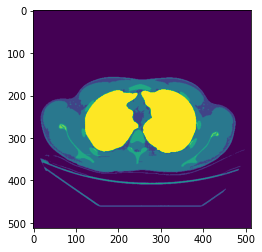

In [410]:
time_start2 = time.time()
patient_id = 9
slices = []
SimRecord = []
Nodule_list = []

time_start_ = time.time()
slices, ID = init_(INPUT_FOLDER, patient_id,slices)
time_elapsed = (time.time() - time_start_)
print(time_elapsed)
time_start_ = time.time()
slices = remove_nonCT(slices)
time_elapsed = (time.time() - time_start_)
print(time_elapsed)
time_start_ = time.time()
scan, ann, vol = scan_dicom(ID)
time_elapsed = (time.time() - time_start_)
print(time_elapsed)
time_start_ = time.time()
Nodule = nodule_list(ann, radiologists,vol)
time_elapsed = (time.time() - time_start_)
print(time_elapsed)


for temp in range(87,88):#0,len(slices)):
    d = slices[temp]
    time_start_ = time.time()
    image = ReScaleIntercept(d.pixel_array, d.RescaleSlope, d.RescaleIntercept)
    time_elapsed = (time.time() - time_start_)
    print(time_elapsed)
    time_start_ = time.time()
    semantic_map,image = semantic_nonROI(image,class1[0],class2[0],class3[0],class4[0],class4[1])
    print(time_elapsed)
    time_start_ = time.time()    
    semantic_map_1, result = depict_semantic_lung(image, semantic_map, region_threshold, lower, region_threshold2)
        ###SimRecord.append(result)
        # Check if nudolue exist. If so, depict the relavant nodule
    print(time_elapsed)
    time_start_ = time.time()    
    semantic_map_2 = depict_semantic_nodule(image, ID, temp, radiologists, semantic_map_1, OUTPUT_FOLDER, scan, ann, vol, Nodule)
    print(time_elapsed)
    time_start_ = time.time()
    
#time_elapsed = (time.time() - time_start2)
#print(time_elapsed)
plt.figure()
plt.imshow(semantic_map_2)
print(result)



In [407]:
#################################
#         Main Script           #
#################################
files = os.listdir(INPUT_FOLDER)
time_start1 = time.time()

for patient_id in range(9,11):
    time_start2 = time.time()
    #patient_id = 7
    slices = []
    SimRecord = []
    Nodule_list = []

    slices, ID = init_(INPUT_FOLDER, patient_id,slices)
    slices = remove_nonCT(slices)
    scan, ann, vol = scan_dicom(ID)
    Nodule = nodule_list(ann, radiologists,vol)

    for temp in range(0,len(slices)):
        d = slices[temp]
        image = ReScaleIntercept(d.pixel_array, d.RescaleSlope, d.RescaleIntercept)
        semantic_map,image = semantic_nonROI(image,class1[0],class2[0],class3[0],class4[0],class4[1])
        semantic_map_1, result = depict_semantic_lung(image, semantic_map, region_threshold, lower, region_threshold2)
        ###SimRecord.append(result)
        # Check if nudolue exist. If so, depict the relavant nodule
        semantic_map_2 = depict_semantic_nodule(image, ID, temp, radiologists, semantic_map_1, OUTPUT_FOLDER, scan, ann, vol, Nodule)

    time_elapsed = (time.time() - time_start2)
    print(time_elapsed)
    
    
time_finish = (time.time() - time_start1)
print(time_finish)
    

Patient ID: LIDC-IDRI-0009
number of slices before: 261
number of slices after: 256
Loading dicom files ... This may take a moment.


/Users/evenwu/opt/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/evenwu/opt/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/evenwu/opt/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


215.47211813926697
Patient ID: LIDC-IDRI-0010
number of slices before: 292
number of slices after: 277
Loading dicom files ... This may take a moment.


/Users/evenwu/opt/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
/Users/evenwu/opt/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:714: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


233.89033603668213
449.36396884918213


In [348]:
print(temp)

13


0.936035916930813


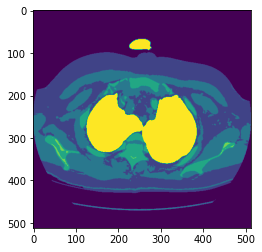

In [189]:
plt.imshow(semantic_map_2)
print(result)

In [289]:
with open('./Data/ImageArray/LIDC-IDRI-0009-0.npy') as f:
    a = np.load(f)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x93 in position 0: invalid start byte